In [5]:
# import necessary modules
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from evaluation import test
from utils import load_data, predict_image, scatter_plot, contour_plot
from utils import plot_boundary, load_cat_dataset, load_iris_2D
from utils import costs_plot

from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures

# from lr import LogisticRegression
from lm import LinearRegression, Ridge, 

rmse = 0.5
[[1.     0.5    0.25   0.125  0.0625]
 [1.     0.2    0.04   0.008  0.0016]]


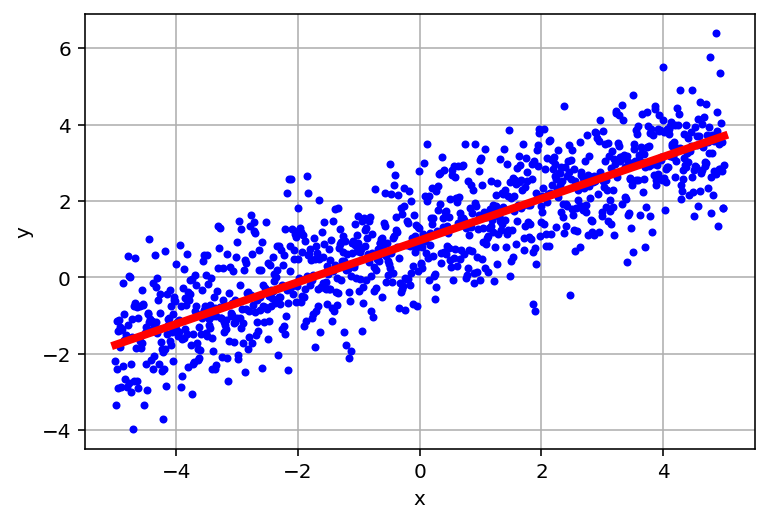

In [6]:
def construct_polynomial_feats(x, degree):
    """
    Args:
        x: numpy array of length N, the 1-D observations
        degree: the max polynomial degree
    Return:
        feat: numpy array of shape Nx(degree+1), remember to include 
        the bias term. feat is in the format of:
        [[1.0, x1, x1^2, x1^3, ....,],
         [1.0, x2, x2^2, x2^3, ....,],
         ......
        ]
    """
    # raise NotImplementedError
    n = x.shape[0]
    res = np.empty((degree+1,n))
    for i in range(degree+1):
        res[i] = np.power(x,i)
    
    return res.T
# Here there are two data points. One data point is 0.5 and other one is 0.2. 
# We try to represent these two data points in higher dimensions.

#helper do not need to change
def plot_curve(x, y, curve_type='.', color='b', lw=2):
    plt.plot(x, y, curve_type, color=color, linewidth=lw)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    
def rmse(pred, label): 
    '''
    This is the root mean square error.
    Args:
        pred: numpy array of length N * 1, the prediction of labels
        label: numpy array of length N * 1, the ground truth of labels
    Return:
        a float value
    '''
    #raise NotImplementedError
    N = pred.shape 
    return np.sqrt(((label - pred) ** 2).sum()/N)[0]
# Hint: get the sqaure root of theta hat in slide 14 (https://mahdi-roozbahani.github.io/cse4240-spring2019.github.io/course/14-linear-regression.pdf)
prediction = np.array([1, 2, 3]) 
label = np.array([1.5, 2.5, 3.5])
print('rmse =',rmse(prediction, label))

    
x = np.array([0.5, 0.2]) 
x_feat = construct_polynomial_feats(x, 4)
print(x_feat)
#helper, do not need to change

POLY_DEGREE = 5
NUM_OBS = 1000

rng = np.random.RandomState(seed=4)

true_weight = rng.rand(POLY_DEGREE + 1, 1)
true_weight[2:, :] = 0
x_all = np.linspace(-5, 5, NUM_OBS)
x_all_feat = construct_polynomial_feats(x_all, POLY_DEGREE)
y_all = np.dot(x_all_feat, true_weight) + rng.randn(x_all_feat.shape[0], 1) # in the second term, we add noise to data
# Note that here we try to produce y_all as our training data
plot_curve(x_all, y_all) # Data with noise that we are going to predict
plot_curve(x_all, np.dot(x_all_feat, true_weight), curve_type='-', color='r', lw=4) # the groundtruth information

indices = rng.permutation(NUM_OBS)

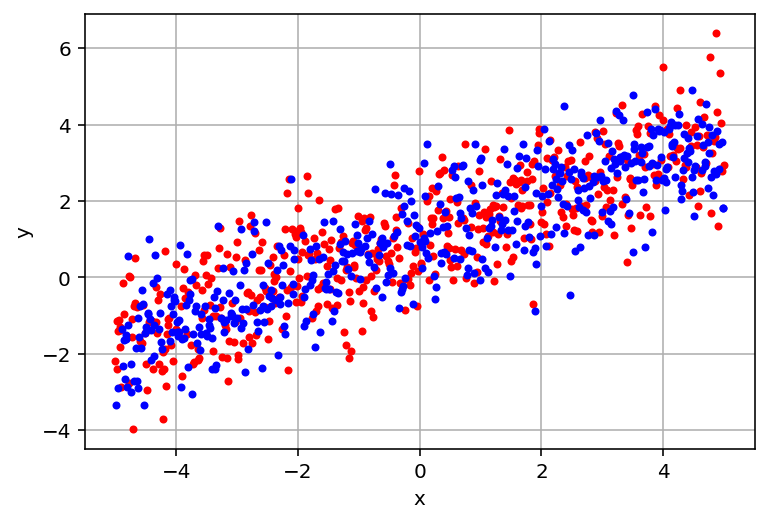

In [7]:
class LinearReg(object):
    @staticmethod 
    # static method means that you can use this method or function for any other classes, it is not specific to LinearReg
    def fit_closed(xtrain, ytrain):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytarin: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        weight = np.linalg.inv(xtrain.T.dot(xtrain)).dot(xtrain.T).dot(ytrain)
        return weight
    
    @staticmethod
    def fit_GD(xtrain, ytrain, epochs=100, learning_rate=0.001,plot_loss=False):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N, D = xtrain.shape
        weight = np.zeros((D,1))
        costs = []
        for i in range(epochs):
            prediction = np.dot(xtrain, weight)
            error = prediction - ytrain
            weight = weight - (learning_rate * (1/N) * np.dot(xtrain.T, error))
            if plot_loss:
                cost = rmse((xtrain.dot(weight)), ytrain)
                costs.append(cost)
        if plot_loss:
            fig, ax = plt.subplots()
            ax.set(xlabel="# Epochs", ylabel="RMSE per Epoch")
            ax.plot(range(epochs), costs)
        return weight
    @staticmethod
    def fit_SGD(xtrain, ytrain, epochs=100, learning_rate=0.001, plot_loss=False):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N, D = xtrain.shape
        weight = np.zeros((D,1))
        costs = []
        for i in range(epochs):
            #indices = np.arange(N)
            #np.random.shuffle(indices)
            #xtrain = xtrain[indices]
            #ytrain = ytrain[indices]
            for j in range(N):
                deriv = (xtrain[j].dot(weight) - ytrain[j]) * xtrain[[j]]
                #print(deriv.shape, xtrain[j].shape)
                weight -= learning_rate*deriv.T
            if plot_loss:
                preds = np.dot(xtrain, weight)
                cost = rmse(preds, ytrain)
                costs.append(cost)
        if plot_loss:
            fig, ax = plt.subplots()
            ax.set(xlabel="# Epochs", ylabel="RMSE per Epoch")
            ax.plot(range(epochs), costs)
        return weight
    @staticmethod
    def predict(xtest, weight):
        """
        Args:
            xtest: NxD numpy array, where N is number 
                   of instances and D is the dimensionality of each 
                   instance
            weight: Dx1 numpy array, the weights of linear regression model
        Return:
            prediction: Nx1 numpy array, the predicted labels
        """
        #raise NotImplementedError
        #print(xtest.shape, weight.shape, weight.T.shape)
        return (xtest.dot(weight))
# Hint: in the fit function, use close form solution of the linear regression to get weights. 
# For inverse, you can use numpy linear algebra function  
# For the predict, you need to use linear combination of data points and their weights (y = w0*1+w1*X1+...)
#helper, do not need to change

train_indices = indices[:NUM_OBS//2]
test_indices = indices[NUM_OBS//2:]

plot_curve(x_all[train_indices], y_all[train_indices], color='r')
plot_curve(x_all[test_indices], y_all[test_indices], color='b')

In [8]:
#helper, do not need to change

weight = LinearReg.fit_closed(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 0.9222


test rmse: 1.1695


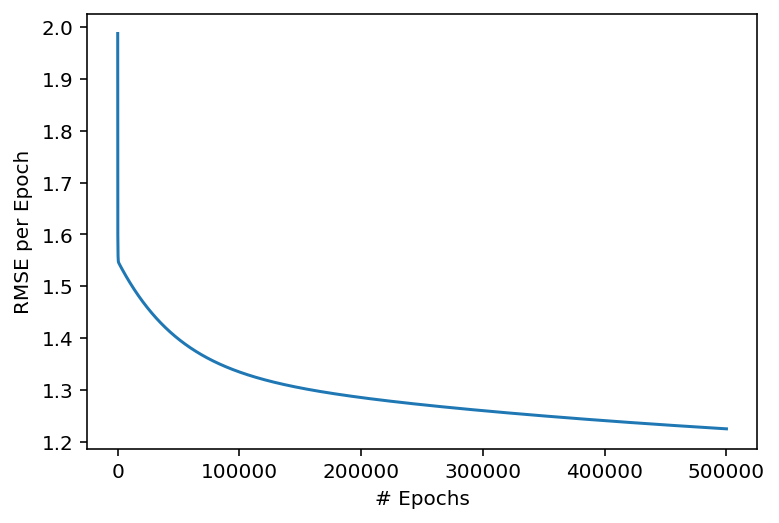

In [9]:
weight = LinearReg.fit_GD(x_all_feat[train_indices], y_all[train_indices], epochs=500000, learning_rate=1e-7,
                          plot_loss=True)
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 1.1695


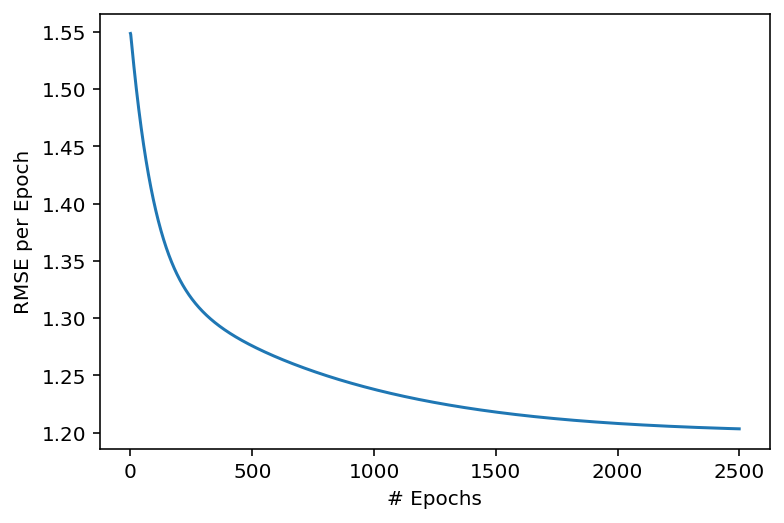

In [10]:
weight = LinearReg.fit_SGD(x_all_feat[train_indices], y_all[train_indices], epochs=2500, learning_rate=1e-7,
                           plot_loss=True)
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

In [28]:
sub_train = train_indices[:10]
weight = LinearReg.fit_closed(x_all_feat[sub_train], y_all[sub_train])
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(y_true=y_all[test_indices], y_pred=y_test_pred))

reg = linear_model.LinearRegression(fit_intercept=False).fit(x_all_feat[sub_train], y_all[sub_train])
np.sqrt(mse(y_true=y_all[test_indices], 
            y_pred=reg.predict(x_all_feat[test_indices])))

test rmse: 2.1910


2.1909845062955964

2.1909845062955458

test rmse: 2.1910


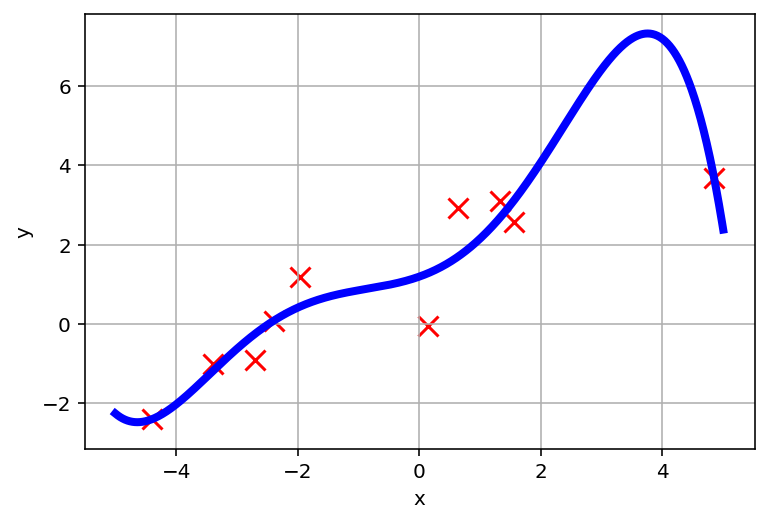

In [19]:
#helper, do not need to change

y_pred = LinearReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred, curve_type='-', color='b', lw=4)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

In [13]:
class RidgeReg(LinearReg):

    @staticmethod
    def fit_closed(xtrain, ytrain, c_lambda):
        N, D = xtrain.shape
        L = np.eye(D)
        L[0,0] = 0
        weight = np.linalg.inv(xtrain.T.dot(xtrain) + c_lambda * L).dot(xtrain.T).dot(ytrain)
        return weight
    
    @staticmethod
    def fit_GD(xtrain, ytrain, c_lambda, epochs=100, learning_rate=0.001,plot_loss=False):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N, D = xtrain.shape
        weight = np.zeros((D,1))
        costs = []
        for i in range(epochs):
            preds = np.dot(xtrain, weight)
            error = preds - ytrain

            gradient = np.dot(xtrain.T, error)
            weight[0] -= learning_rate * gradient[0] / N
            weight[1:] -= learning_rate * (gradient[1:] +  c_lambda * weight[1:])/N
#             weight[1:] = weight[1:] * (1- learning_rate * c_lambda/N)- (learning_rate * (1/N) * gradient[1:])

            cost = rmse(preds, ytrain)
            costs.append(cost)
        if plot_loss:
            fig, ax = plt.subplots()
            costs = costs[:100]
            ax.plot(range(len(costs)), costs)
        return weight
    @staticmethod
    def fit_SGD(xtrain, ytrain, c_lambda, epochs=100, learning_rate=0.001,plot_loss=False):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N, D = xtrain.shape
        weight = np.zeros((D,1))
        costs = []
        for i in range(epochs):
            for j in range(N):
                prediction = np.dot(xtrain[j], weight)
                error = prediction - ytrain[j]
                gradient = (xtrain[[j]] * error).T
                weight[0] -= learning_rate * gradient[0]
                weight[1:] -= learning_rate * (gradient[1:] +  c_lambda * weight[1:]/N)
            if plot_loss:
                preds = np.dot(xtrain, weight)
                cost = rmse(preds, ytrain)
                costs.append(cost)
        if plot_loss:
            fig, ax = plt.subplots()
            costs = costs[:100]
            ax.plot(range(len(costs)), costs)
        return weight

In [52]:
#helper, do not need to change

weight = RidgeReg.fit_closed(x_all_feat[train_indices], y_all[train_indices],  c_lambda=1)
y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
reg_r = linear_model.Ridge(fit_intercept=False).fit(x_all_feat[train_indices], y_all[train_indices])
np.sqrt(mse(y_true=y_all[test_indices], 
            y_pred=reg_r.predict(x_all_feat[test_indices])))
ridge_cv = linear_model.RidgeCV(alphas=[1e-3,1e-2,1e-1, 1,1e2, 1e3, 1e4], 
                                fit_intercept=False).fit(x_all_feat[train_indices], y_all[train_indices])
ridge_cv.alpha_

test rmse: 0.9223


0.9223099125007483

1.0

In [58]:
ridge_cv = linear_model.RidgeCV(alphas=[1e-3,1e-2,1e-1, 1,1e2, 1e3, 1e4,1e5,1e6,1e7], 
                                fit_intercept=False).fit(x_all_feat[sub_train], y_all[sub_train])
ridge_cv.alpha_

100000.0

test rmse: 1.2115


1.6589070311242773

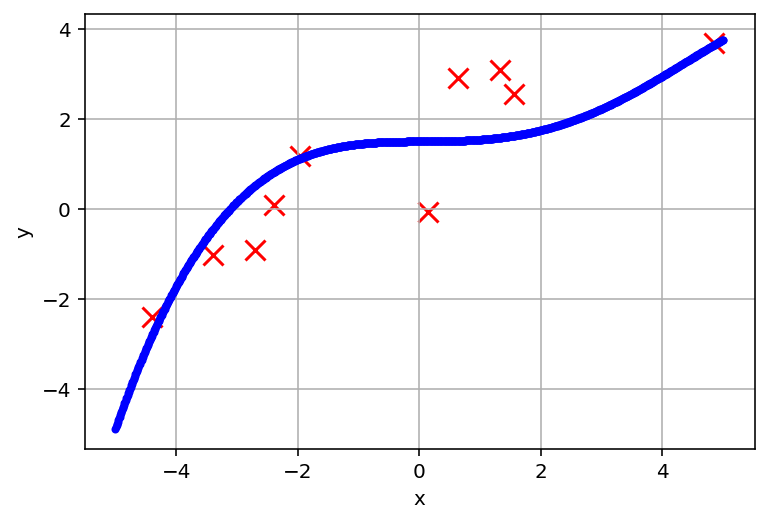

In [61]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_closed(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)


reg_r = linear_model.Ridge(alpha=100000, fit_intercept=False).fit(x_all_feat[sub_train], y_all[sub_train])
np.sqrt(mse(y_true=y_all[test_indices], 
            y_pred=reg_r.predict(x_all_feat[test_indices])))

test rmse: 1.6673
-- Epoch 1
Norm: 538410544965.72, NNZs: 6, Bias: 0.000000, T: 10, Avg. loss: 146655594149953110236200960.000000
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6560634655166.35, NNZs: 6, Bias: 0.000000, T: 20, Avg. loss: 17403053906507526659798208610304.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 3615508601314.98, NNZs: 6, Bias: 0.000000, T: 30, Avg. loss: 20366072025310350500025727975424.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 5972627245782.25, NNZs: 6, Bias: 0.000000, T: 40, Avg. loss: 10698839771341503760780759138304.000000
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 3384995379969.28, NNZs: 6, Bias: 0.000000, T: 50, Avg. loss: 15473813423057403494525871063040.000000
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 5699838562109.16, NNZs: 6, Bias: 0.000000, T: 60, Avg. loss: 8232709682058354787688371978240.000000
Total training time: 0.00 seconds.
Convergence after 6 epochs took 0.00 seconds


2355111633881974.5

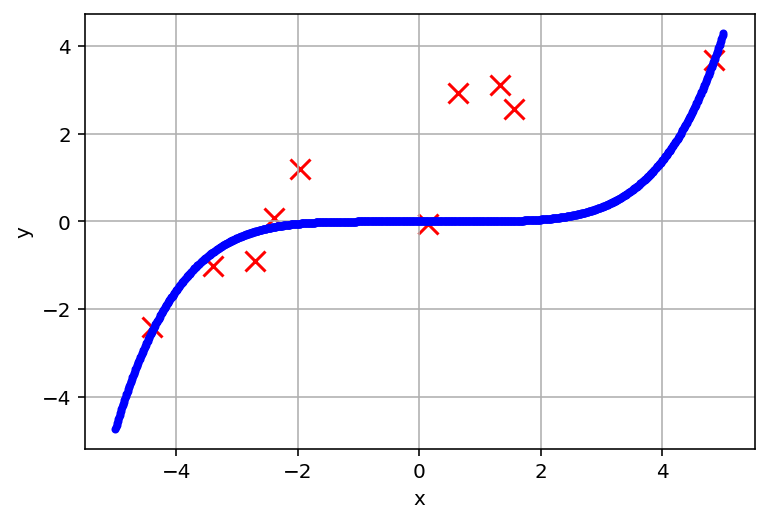

In [65]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_SGD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-7)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse) #1.6672

sgd_r = linear_model.SGDRegressor(fit_intercept=False, shuffle=False,
                                  verbose=1,
                                 ).fit(x_all_feat[sub_train], y_all[sub_train].flatten())
np.sqrt(mse(y_true=y_all[test_indices], 
            y_pred=sgd_r.predict(x_all_feat[test_indices])))

test rmse: 1.6446


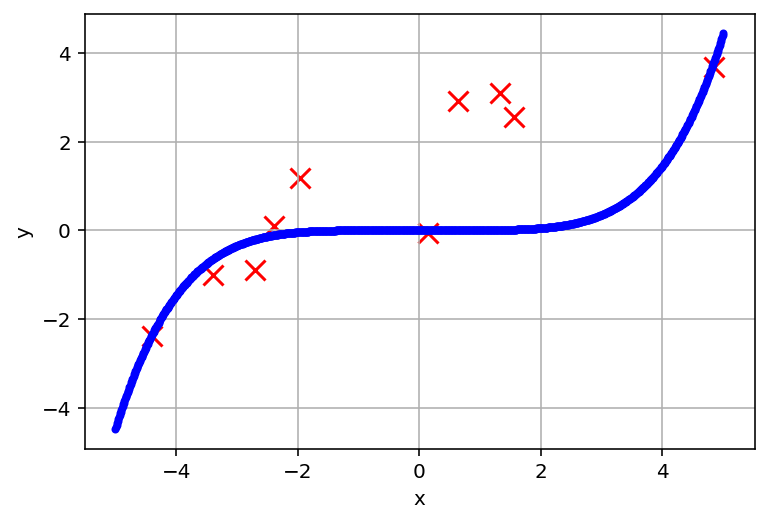

In [16]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_GD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-7)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show();

In [ ]:
reg = LinearRegression()
reg.fit(diabetes_X_train, diabetes_y_train)
reg.coef_

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = linear_model.LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show();

In [ ]:
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show();

In [ ]:
from sklearn.model_selection import cross_val_predict

lr = linear_model.LinearRegression()
boston = datasets.load_boston()
y = boston.target

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, boston.data, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show();

In [ ]:
lr = LinearRegression()
predicted = cross_val_predict(lr, boston.data, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show();

In [ ]:
# Loading some example data
boston = datasets.load_boston()
X = boston.data
y = boston.target

reg3 = linear_model.LinearRegression()
reg3.fit(X, y)
reg3.coef_

In [ ]:
# Training classifiers
reg3 = LinearRegression()
reg3.fit(X, y)
reg3.coef_

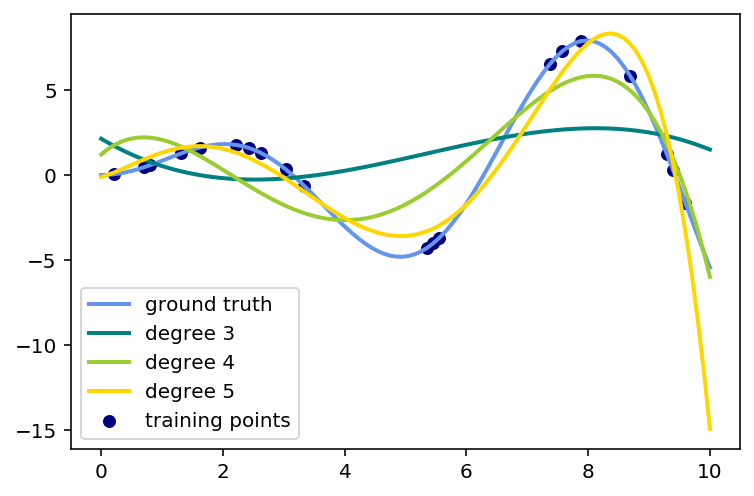

In [2]:
from sklearn.pipeline import make_pipeline


def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)


# generate points used to plot
x_plot = np.linspace(0, 10, 100)

# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:20])
y = f(x)

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), linear_model.Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show();


In [3]:
reg = Ridge()
reg.fit(X, y)
reg.predict(X)

Ridge(alpha=None, fit_intercept=True)

array([0.02801631, 0.15751446, 0.18341409, 0.31291223, 0.39061112,
       0.5460089 , 0.59780816, 0.64960742, 0.75320594, 0.83090483,
       1.34889742, 1.37479705, 1.40069668, 1.86689001, 1.91868927,
       1.99638816, 2.20358519, 2.35898297, 2.3848826 , 2.43668186])

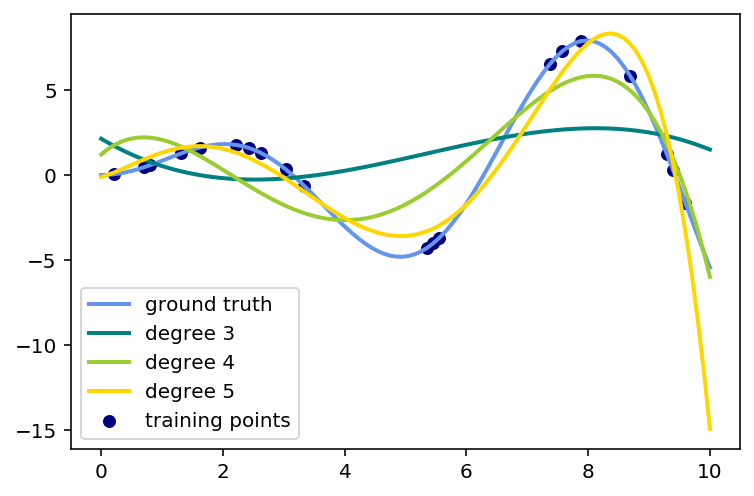

In [4]:
colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show();